# Prepare Partial Exponential State

The notebook shows how to construct the following state:

$$ |\psi\rangle = \sum_{x_0}^{x_1}\sqrt{\frac{e^{-ar}}{Z}}|r\rangle $$
$$Z = \sum_{x_0}^{x_1}\sqrt{e^{-ar}}$$

The methodology is to load the state on the full range of states, then use exact amplitude amplification to leave only the wanted part:

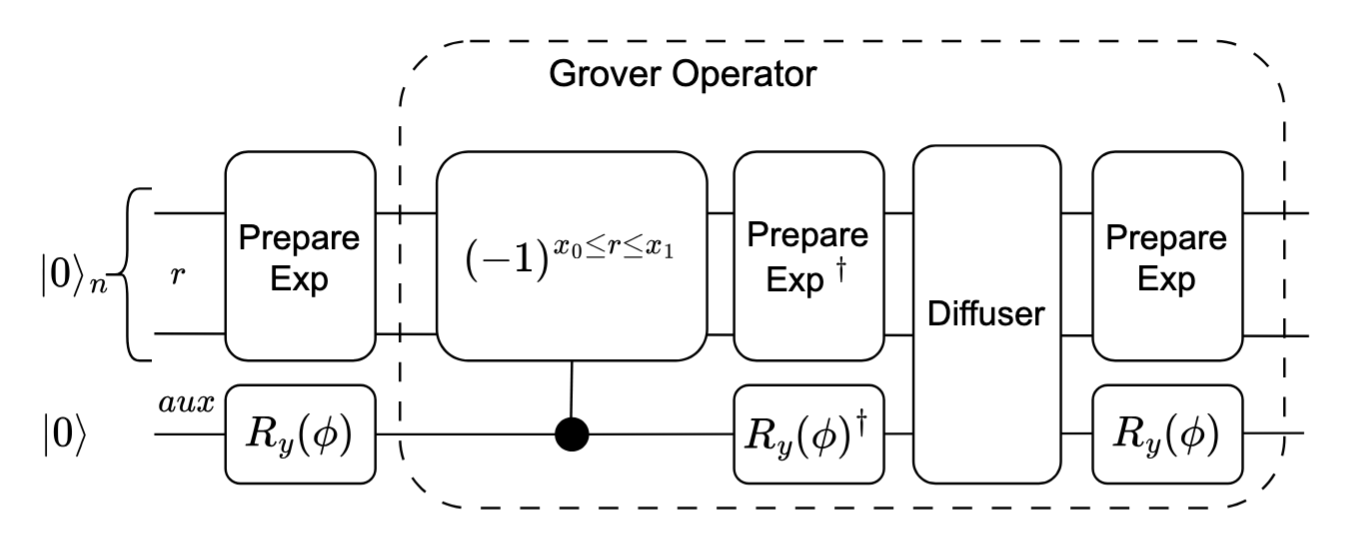

## Exponential State Preparation on the Full Interval

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from classiq import *

EXP_RATE = 0.5
NUM_QUBITS = 5


@qfunc
def main(x: Output[QNum]):
    allocate(NUM_QUBITS, x)
    prepare_exponential_state(-EXP_RATE, x)


execution_preferences = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)
qprog = synthesize(create_model(main, execution_preferences=execution_preferences))
res = execute(qprog).get_sample_result()

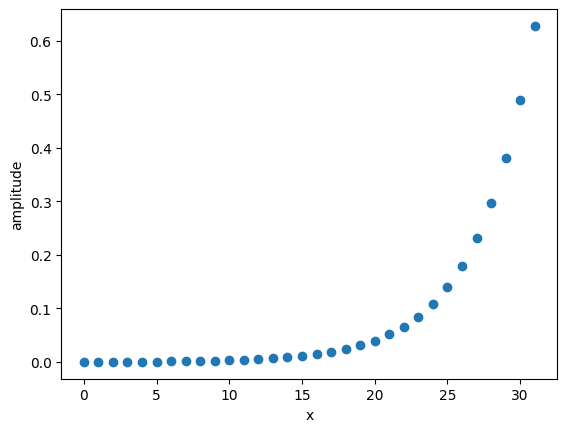

In [2]:
def parse_res(r, plot=True):
    x = []
    amps = []
    r = res
    for s in r.parsed_state_vector:
        if s.state["x"] in x:
            amps[x.index(s.state["x"])] += np.abs(s.amplitude)
        else:
            x.append(s.state["x"])
            amps.append(np.abs(s.amplitude))
    if plot:
        plt.scatter(x, amps)
        plt.xlabel("x")
        plt.ylabel("amplitude")
    return x, amps


x, amps = parse_res(res)

## Exp State on a Specific Interval with Exact Amplitude Amplification

In [3]:
X0 = 15
X1 = 29
X_MIN = 0
X_MAX = 2**NUM_QUBITS - 1


def get_good_states_amplitude(x0, x1, exp_rate, num_qubits):
    x_min = 0
    x_max = 2**NUM_QUBITS - 1
    """for the range[x0, x1] including x0 and x1"""
    return np.sqrt(
        (np.exp(exp_rate * x1) - np.exp(exp_rate * x0))
        / (np.exp(exp_rate * x_max) - np.exp(exp_rate * x_min))
    )


AMPLITUDE = get_good_states_amplitude(X0, X1, EXP_RATE, NUM_QUBITS)
print(AMPLITUDE)

0.6062541106972759


Quantum program link: https://platform.classiq.io/circuit/2yrQCbA5Ri4kiCg6Z8Hr6f5ilEz


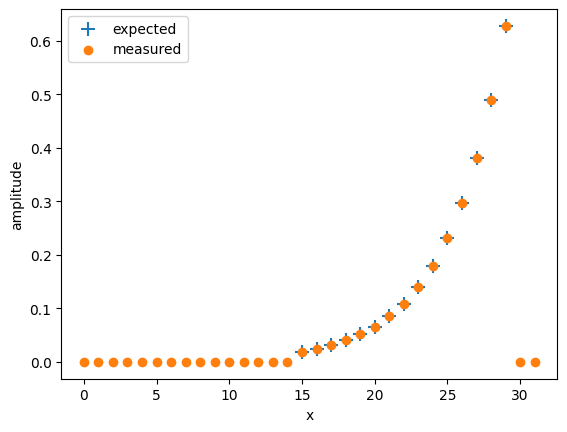

In [4]:
from classiq.qmod.symbolic import logical_and


@qperm
def oracle_comp(x: Const[QNum], res: QBit):
    res ^= logical_and(x >= X0, x <= X1)


@qfunc
def main(x: Output[QNum]):
    allocate(NUM_QUBITS, x)
    exact_amplitude_amplification(
        amplitude=AMPLITUDE,
        oracle=lambda _x: phase_oracle(oracle_comp, _x),
        space_transform=lambda _x: prepare_exponential_state(-EXP_RATE, _x),
        packed_qvars=x,
    )


qprog = synthesize(create_model(main, execution_preferences=execution_preferences))
show(qprog)

res = execute(qprog).get_sample_result()
x, measured_amps = parse_res(res, plot=False)

# compare to expected amplitudes
grid = np.arange(X0, X1 + 1)
expected_amps = np.sqrt(np.exp(EXP_RATE * grid))
expected_amps /= np.linalg.norm(expected_amps)

plt.scatter(grid, expected_amps, marker="+", s=100, label="expected")
plt.scatter(x, measured_amps, label="measured")
plt.xlabel("x")
plt.ylabel("amplitude")
plt.legend()
plt.show()

### Adjusting If a Single Grover is Not Enough

If the desired range does not hold enough amplitude, it is enough to load the end of the range (for a positive `EXP_RATE`) or the beginning of the range (for a negative `EXP_RATE`), then finish with a modular adder:

In [5]:
from classiq.qmod.symbolic import logical_and

X0 = 3
X1 = 13
X_MIN = 0
X_MAX = 2**NUM_QUBITS - 1

AMPLITUDE = get_good_states_amplitude(X0, X1, EXP_RATE, NUM_QUBITS)

print(AMPLITUDE)

0.011071508393649327


This fraction of good states is not enough for a single Grover iteration to amplify to 1. So, first load the same sized interval at the end of the range:

0.996625424765961
Quantum program link: https://platform.classiq.io/circuit/2yrQI478Km0GkMYwVYXJ95cBlnZ


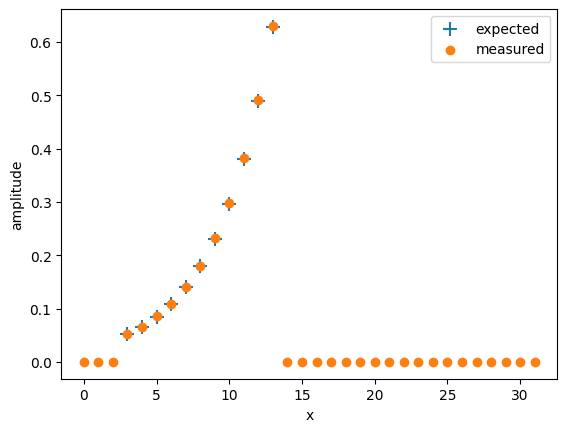

In [6]:
X_MAX = 2**NUM_QUBITS - 1
if EXP_RATE > 0:
    AMPLITUDE = get_good_states_amplitude(
        X_MAX - (X1 - X0), X_MAX, EXP_RATE, NUM_QUBITS
    )
else:
    AMPLITUDE = get_good_states_amplitude(0, X1 - X0, EXP_RATE, NUM_QUBITS)

print(AMPLITUDE)


@qperm
def oracle_comp(x: Const[QNum], res: QBit):
    if EXP_RATE > 0:
        res ^= x >= X_MAX - (X1 - X0)
    else:
        res ^= x <= (X1 - X0)


@qfunc
def main(x: Output[QNum]):
    allocate(NUM_QUBITS, x)
    exact_amplitude_amplification(
        amplitude=AMPLITUDE,
        oracle=lambda _x: phase_oracle(oracle_comp, _x),
        space_transform=lambda _x: prepare_exponential_state(-EXP_RATE, _x),
        packed_qvars=x,
    )
    # shift to the wanted domain
    if EXP_RATE > 0:
        x += -(X_MAX - X1)
    else:
        x += X0


qmod = create_model(main, execution_preferences=execution_preferences)
qprog = synthesize(qmod)
show(qprog)

res = execute(qprog).get_sample_result()
x, measured_amps = parse_res(res, plot=False)

# compare to expected amplitudes
grid = np.arange(X0, X1 + 1)
expected_amps = np.sqrt(np.exp(EXP_RATE * grid))
expected_amps /= np.linalg.norm(expected_amps)

plt.scatter(grid, expected_amps, marker="+", s=100, label="expected")
plt.scatter(x, measured_amps, label="measured")
plt.xlabel("x")
plt.ylabel("amplitude")
plt.legend()
plt.show()

### Verifying the Results

In [7]:
x, measured_amps = parse_res(res, plot=False)
for i, amp in zip(x, measured_amps):
    if i >= X0 and i <= X1:
        assert np.isclose(amp, expected_amps[i - X0], atol=0.01)